In [15]:
import numpy as np
import matplotlib.pyplot as plt
import random
import collections

In [16]:
class El_Farol_env:
    def __init__(self, NUM_AGENTS = 100, M = 5, N = 10, THR = 30, SEED=42):
        np.random.seed(SEED)
#         self.num_steps = NUM_STEPS
        self. num_agents = NUM_AGENTS # Number of agents
        self.M = M # Number of weeks to remember (memory)
        self.N = N # Number of strategies per agent
        self.THR = 60 # Occupancy threshold
        
        # Initialize random decision weights for all players
        self.weight_mat = np.random.uniform(-1, 1, (self.num_agents, self.N, self.M + 1))
        
        # Initialize M random instances of weeks of attendance
        self.A_M = collections.deque(maxlen = self.M)
        for i in range(self.M):
            self.A_M.append(np.random.randint(0, self.num_agents-1))
        
        # Initialize the current time step's attendance: 
        self.A_t = np.random.randint(0, self.num_agents-1)
        
    def make_decision(self, w_vec, A_vec, s_ind=None):
        '''
        # Decision making for one agent:
        # Inputs:
        #       w_vec: [N x M+1] - Initialized weight vectors (and bias) for one agent's strategies 
        #       A_vec: [M x 1] - Attendance for the last M steps (Cirular buffer)
        #       s_ind: Previous best decision strategy, if None, estimate based on memory
        # Outputs:
        #       d: [0, 1] ~ [DON'T GO, GO]
        #       S_guess: Scalar - Estimated number of attendees for current time step (mostly used for troubleshooting)
        '''
        
        S = np.zeros((self.N, 1))
        E = np.zeros((self.N, 1))
        
        if s_ind is None: # The first step
            for i in range(len(w_vec)):
                S[i] = 100 * (np.dot(w_vec[i,:-1], A_vec)) + w_vec[i,-1]
                E[i] = np.sum(np.abs(S[i].item() - np.array(A_vec))) # Errors in the previous rounds
            # Select the strategy with the smallest error:
            s_ind = np.argmin(E)
            S_guess = S[s_ind]
        else:
            S_guess = 100 * (np.dot(w_vec[s_ind,:-1], A_vec)) + w_vec[s_ind,-1]
        
        
        # Make Decision:
        if S_guess <= self.THR: 
            d = 1 # GO
        else: 
            d = 0 # DON'T GO
    
        return d, S_guess
    
    def update_s_star(self, w_vec, A_vec, A_t):
        '''
        # Decision making for one agent:
        # Inputs:
        #       w_vec: [N x M+1] - Initialized weight vectors (and bias) for one agent's strategies 
        #       A_vec: [M x 1] - Attendance for the last M steps (Cirular buffer)
        #       A_t: Current time step's attendance
        # Outputs:
        #       s_ind: Scalar integer: New optimum strategy for the agent
        #       S_guess: New estimated number of attendees (mostly used for troubleshooting)
        '''
        S = np.zeros((self.N, 1))
        E = np.zeros((self.N, 1))
          
        for i in range(len(w_vec)):
            S[i] = 100 * (np.dot(w_vec[i,:-1], A_vec)) + w_vec[i,-1]
            E[i] = np.sum(np.abs(S[i].item() - np.array(A_vec))) # Errors in the previous rounds

        s_ind = np.argmin(E).astype(int)
        S_guess = S[s_ind]
        
        return s_ind, S_guess
        
            
        
    def take_steps(self, num_steps=10):
        '''
        # Simulate multiple weeks of events and decisions
        # Inputs:
        #       num_steps: Scalar integer - number of weeks to simulate
        '''
        s_star = np.zeros((self.num_agents, 1)).astype(int)
        S_guessed = np.zeros((self.num_agents, 1))
        agents_performance = np.zeros((self.num_agents, 1))
        A_ts = np.zeros((num_steps, 1)) # Actual number of attendees
        d = np.zeros((self.num_agents, 1))
        
        # Iterating for desired number of steps:
        for step_i in range(num_steps):
#             print("Step: ", step_i)
            # Iterating for each agent:
            for agent_j in range(self.num_agents):
                w_vec = np.squeeze(self.weight_mat[agent_j,:,:])
                A_vec = self.A_M
                if step_i == 0: # Initial step 
                    s_ind = None
                else:
                    s_ind = s_star[agent_j]
                # Make decision:
                d[agent_j], S_guessed[agent_j] = self.make_decision(w_vec=w_vec, A_vec=A_vec, s_ind=s_ind)
            
            # Calculate A_t
            A_t = np.sum(d) # Number of agents who decided to go
            A_ts[step_i] = A_t
            
            # Update circular A_M buffer:
            self.A_M.append(A_t)
            
            # Update S_star for each agent - based on observed A_t
            for agent_j in range(self.num_agents):
                w_vec = np.squeeze(self.weight_mat[agent_j,:,:])
                A_vec = self.A_M
                s_star[agent_j], _ = self.update_s_star(w_vec=w_vec, A_vec=A_vec, A_t=A_t)
                # Estimate performance of each agent
                if (S_guessed[agent_j] <= self.THR) and (d[agent_j] == 1): # Correct decision was made
                    agents_performance[agent_j] += 1
                    
        # What do we want the function to retun?
        return A_ts, agents_performance
        

In [17]:
env = El_Farol_env()
A_ts, agents_performance = env.take_steps(num_steps=500)

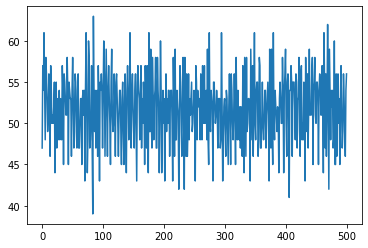

In [18]:
plt.plot(A_ts)

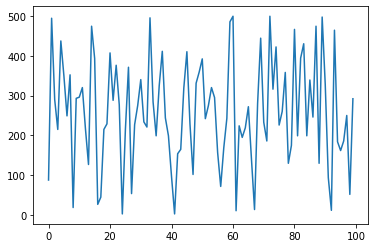

In [19]:
plt.plot(agents_performance)

In [ ]:
# env = El_Farol_env()

# w_vec = np.squeeze(env.weight_mat[1, :, :])
# A_vec = env.A_M
# A_t = 44

# np.array(A_vec)
# d, S_guess = env.make_decision(w_vec=w_vec, A_vec=A_vec, s_ind=None)
# print(d)
# print(S_guess)